###  Stock Market Sentiment Analysis

#### Author-Kirti Gupta

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
#!pip install wordcloud
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#!pip install textblob
#!pip install xgboost
import  textblob
import xgboost
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from textblob import Word 
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

import spacy
from spacy import displacy
from spacy.matcher import Matcher


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

C:\Users\kirti\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.preprocessing import normalize,Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.cluster import KMeans 
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.preprocessing import normalize,Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score,pairwise_distances

#### Import Dataset

In [4]:
st_mkt=pd.read_csv('F:/The Spark Foundation/india-news-headlines.csv')

In [5]:
st_mkt.head(10)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
5,20010102,unknown,Extra buses to clear tourist traffic
6,20010102,unknown,Dilute the power of transfers; says Riberio
7,20010102,unknown,Focus shifts to teaching of Hindi
8,20010102,unknown,IT will become compulsory in schools
9,20010102,unknown,Move to stop freedom fighters' pension flayed


In [6]:
st_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


#### Data Audit

In [7]:
#Conversion into date format
st_mkt['publish_date']=pd.to_datetime(st_mkt.publish_date,format='%Y%m%d')

In [8]:
#Filtering data
st_mkt=st_mkt[(st_mkt.headline_category=='business')|(st_mkt.headline_category=='business.india-business')|(st_mkt.headline_category=='business.international-business')| (st_mkt.headline_category=='business.mf-simplified.mf-news')|(st_mkt.headline_category=='business.personal-finance')]

#### Number of Headlines by Year

In [9]:
years=st_mkt.groupby(st_mkt.publish_date.apply(lambda x:pd.Timestamp.strftime(x,'%Y')))[['headline_text']].count()

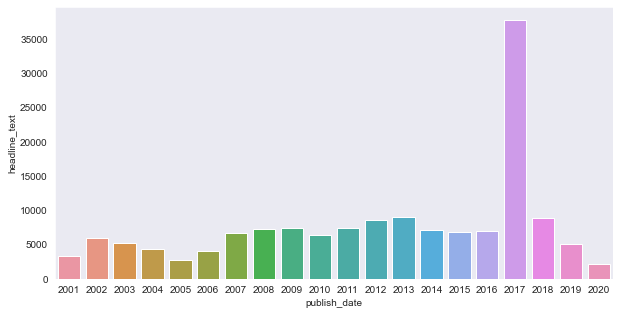

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(x=years.index,y=years.headline_text,data=years)

#### Number of Headlines by Category

In [11]:
c=pd.DataFrame(st_mkt.headline_category.value_counts().reset_index())
c['headline_text']=c.headline_category
c['headline_category']=c['index']
c.drop('index',axis=1,inplace=True)
c.sort_values(by='headline_category',inplace=True,ascending=False)
#c.head(10)

In [12]:
c

,headline_category,headline_text
2,business.personal-finance,1592
4,business.mf-simplified.mf-news,41
1,business.international-business,36356
0,business.india-business,115246
3,business,529


#### Supervised Learning

In [13]:
df=st_mkt[['headline_category','headline_text']]

#### Basic Exploratory Analysis

In [ ]:
df['headline_text'] = df['headline_text'].astype(str)

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['headline_text'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['headline_text'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['headline_text'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['headline_text'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['headline_text'].apply(lambda x: check_pos_tag(x, 'pron')) 


#### Calculating sentiment analysis using TextBlob module

In [14]:
df['headline_text'] = df['headline_text'].astype(str)

In [15]:
df['sentiment'] = df["headline_text"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [16]:
#Calculating scores using sentiments
df['Score']=np.where(df.sentiment<0,0,1)

In [17]:
df.Score.value_counts()

1    136599
0     17165
Name: Score, dtype: int64

In [18]:
# Positive Headline_text Percentage
phead=(df['sentiment']>0).sum()
(phead/len(df["headline_text"]))*100

18.862022319918836

In [19]:
# Neagtive Headline_text Percentage
nhead=(df['sentiment']<0).sum()
(nhead/len(df["headline_text"]))*100

11.16321115475664

In [20]:
# Neutral Headline_text Percentage
neutral_head=(df['sentiment']==0).sum()
(neutral_head/len(df["headline_text"]))*100

69.97476652532453

### Split the data in Train and Test

In [21]:
# train features and labels 
y=df['Score']
X=df['headline_text']

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(130699,)
(23065,)
(130699,)
(23065,)


#### Creating user defined functions for clean the text and pre-process the data

In [22]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [23]:
stop = set(nltk.corpus.stopwords.words('english'))

In [27]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)     #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
   # text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
   # text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
   # text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [28]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [29]:
X_train=pre_process(X_train)
X_test =pre_process(X_test)

#### Vectorization (count, tfidf) for both train & test

In [30]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(2, 3),  
                             encoding='latin-1',
                             max_df=0.9,min_df=0.001)
xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)

In [31]:
xtrain_count

<130699x429 sparse matrix of type '<class 'numpy.int64'>'
	with 128130 stored elements in Compressed Sparse Row format>

#### View the document term metrics

In [32]:
dtm2=pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

In [33]:
dtm2.head(10)

,a dollar,a investor,a new,a of,a u,a year,african market,african market factor,against dollar,against dollar in,...,way to,weak global,weak global cue,week high,week low,will be,world bank,worth r,year high,yes bank
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.581022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', ngram_range=(2, 3),max_df=0.9,min_df=0.001)
tfidf_vect_ngram.fit(df['headline_text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [35]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern='\w{1,}', ngram_range=(2,3), max_df=0.9,min_df=0.001)
tfidf_vect_ngram_chars.fit(df['headline_text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

### Topic Modeling

In [36]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=15, learning_method='batch', max_iter=50)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [37]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['ahead of india to to cut in the r k for india not to k cr of india due to',
 'up to in year tata motor to hit to start up with tie up set for north korea to hire',
 'r cr stake in govt to likely to to meet look to home loan sale of to help roll out',
 'rise in at r on the rise on rise to per share for indian q earnings earnings per earnings per share',
 'rate hike cr in more than r cr in r cr may get plan for to push net profit invest r',
 'in india to be to buy oil price u cash mutual fund to boost to pay per cent how to',
 'to take to raise to launch bank to growth in interest rate govt may may not raise r stock market',
 'to sell set up deal with to set to set up to acquire l t month low to open for a',
 'wall street to make up on up in sensex up sensex close fall to nod for up point car sale',
 'to watch factor to factor to watch watch on to watch on r lakh norm for sensex nifty fuel price fall in',
 'in q in u may be up for to invest fdi in will be on u icici bank price for',
 '

##### Topics
         1.Value of rupees vs dollar.
         2.Oil prices
         3.Airlines:-Air India and Jet Airways
         4.Banks: icici and hdfc banks
         5.Real Estate
         6.Sensex

#### Headlines Data Word Cloud

In [38]:
frequency_words_wo_stop= {}
for data in df['headline_text']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [39]:
from wordcloud import WordCloud ,STOPWORDS

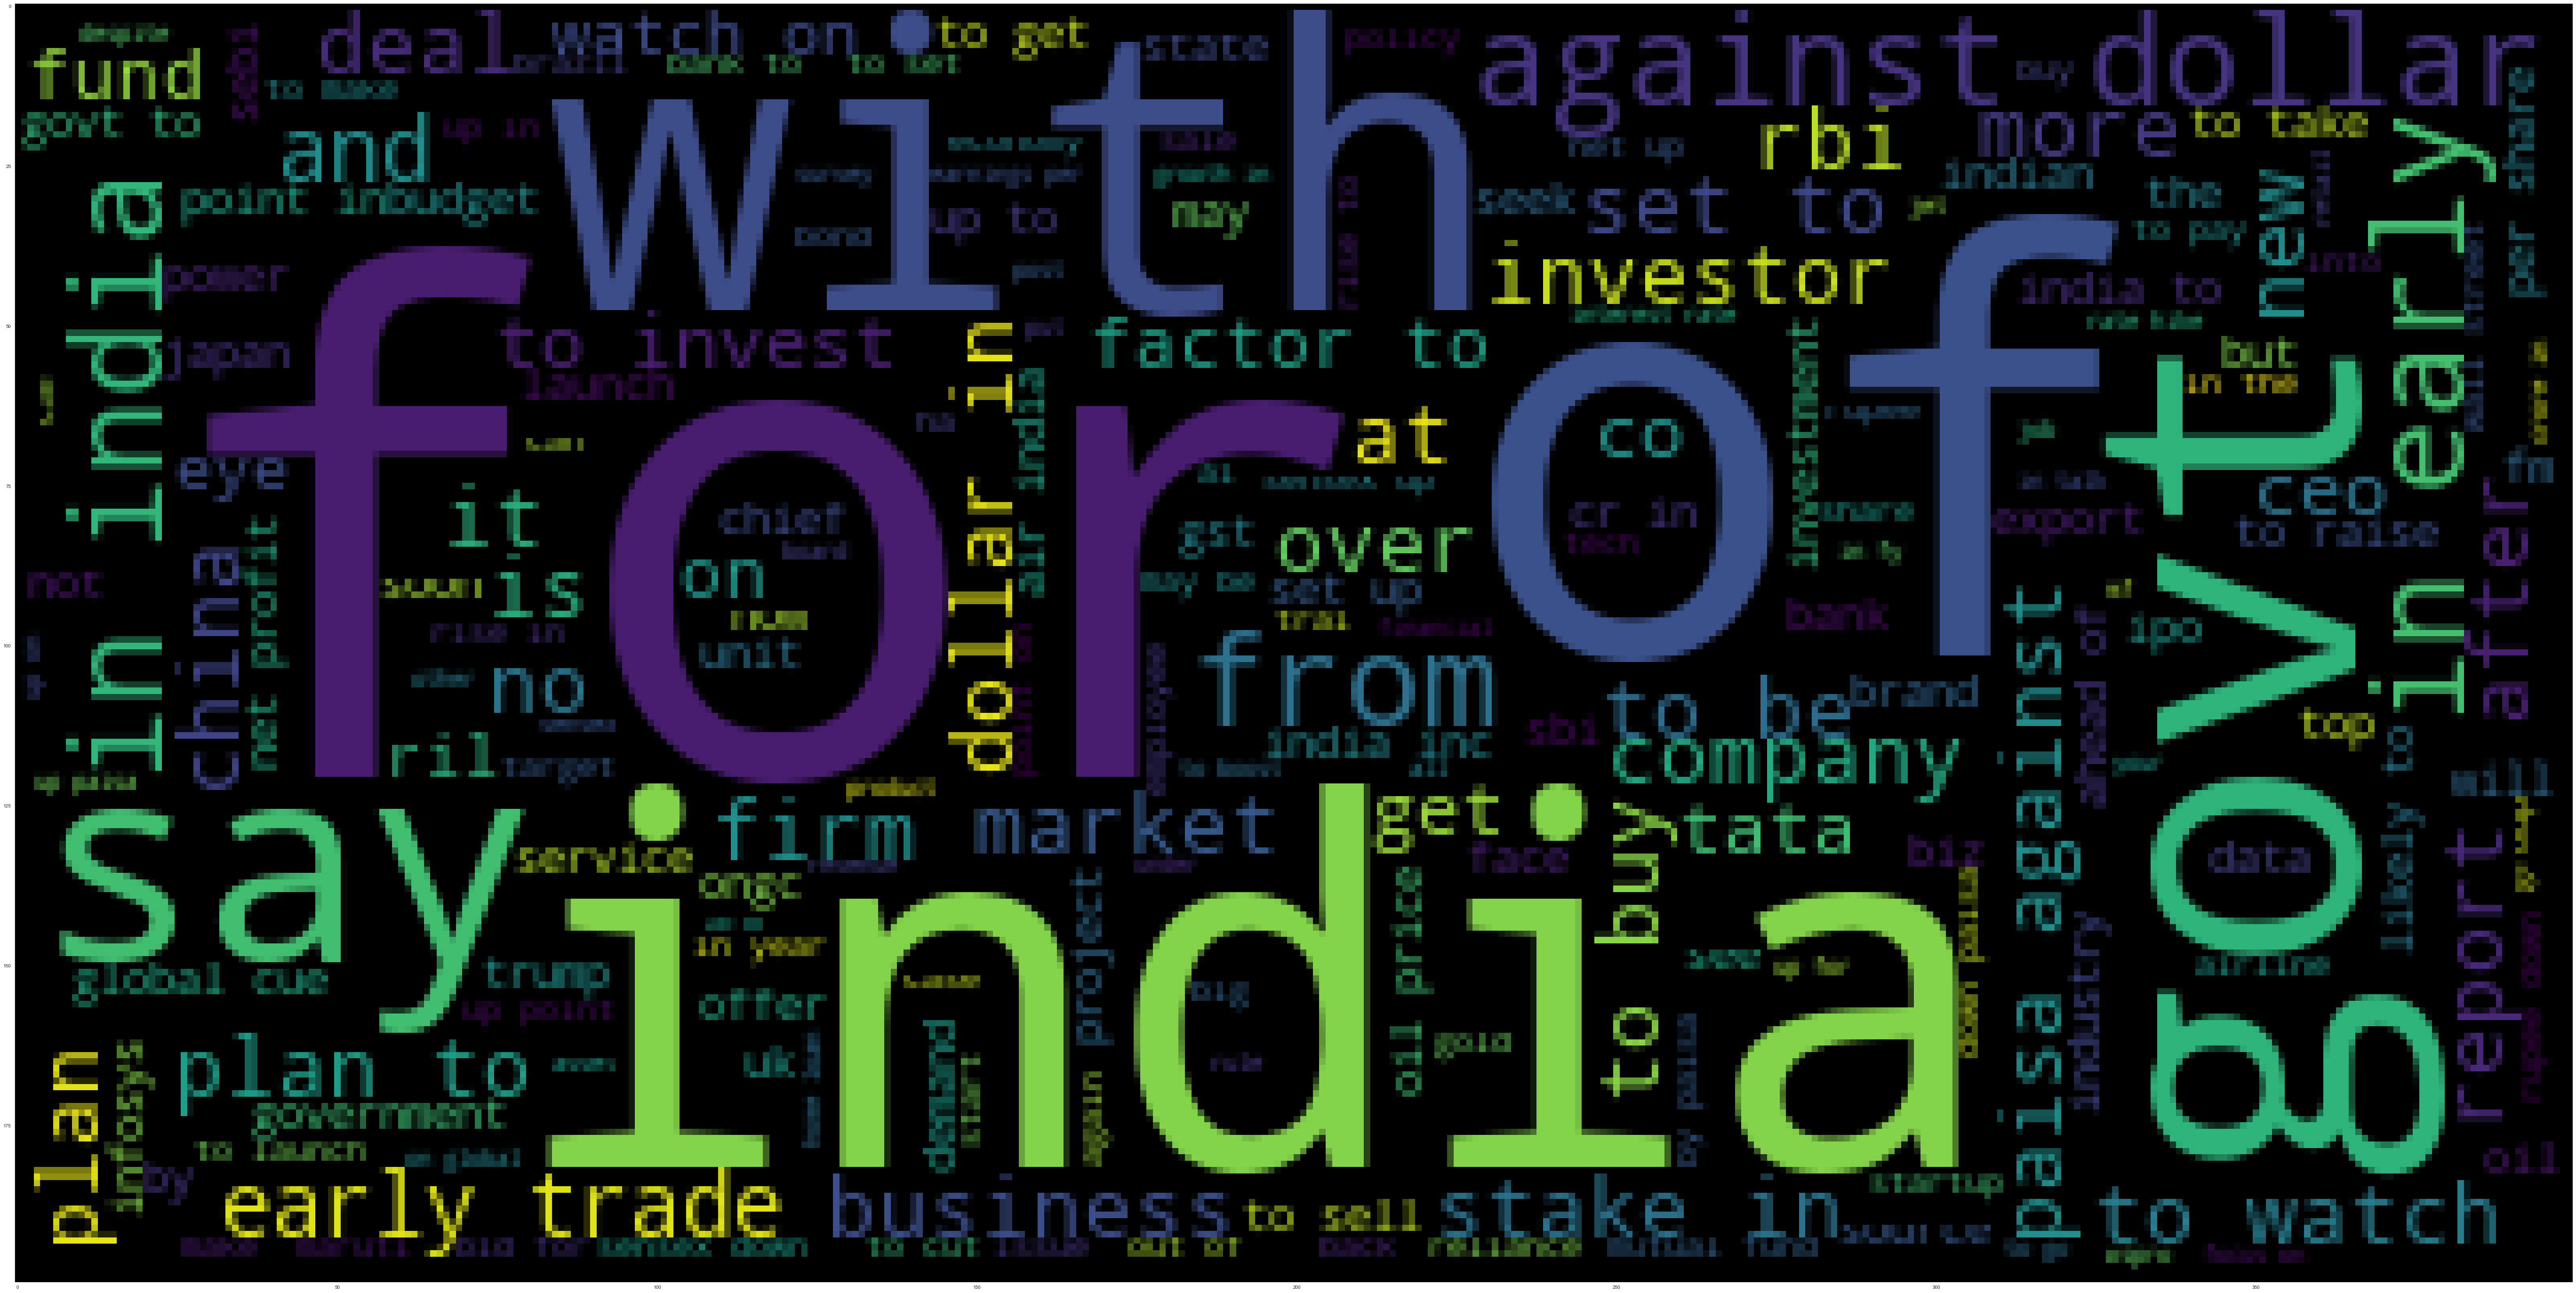

In [40]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

#### Create user defined functions to train the models

In [41]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    
    return metrics.accuracy_score(predictions, valid_y)

#### Building different models with different vectors

In [42]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB for L1, Count Vectors: ", accuracy_L1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)



# Naive Bayes on Character Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("NB for L1, CharLevel Vectors: ", accuracy_L1)

NB for L1, Count Vectors:  0.9001951008020811
NB  for L1, WordLevel TF-IDF:  0.8944721439410362
NB  for L1, N-Gram Vectors:  0.8974203338391502
NB for L1, CharLevel Vectors:  0.8948623455451984


In [43]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Logistic Regression on Character Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9027530890960329
LR  for L1, WordLevel TF-IDF:  0.9028831562974203
LR  for L1, N-Gram Vectors:  0.9000650336006937
LR for L1, CharLevel Vectors:  0.9312811619336657


In [44]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_count, y_train, xtest_count, y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)



# Linear SVC on Character Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("SVC for L1, CharLevel Vectors: ", accuracy_L1)

SVC  for L1, Count Vectors:  0.9027530890960329
SVC  for L1, WordLevel TF-IDF:  0.9026663776284414
SVC  for L1, N-Gram Vectors:  0.9000650336006937
SVC for L1, CharLevel Vectors:  0.9415131151094732


In [45]:
#Random Forest
# Random Forest on Count Vectors and TF-IDF
accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Random Forest on Word Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Random Forest on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Random Forest on Character Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9013657056145675
LR  for L1, WordLevel TF-IDF:  0.9014090613483633
LR  for L1, N-Gram Vectors:  0.8993279861261652
LR for L1, CharLevel Vectors:  0.938608280945155


In [46]:
#XGBoosting
# XGBoosting on Count Vectors and TF-IDF
accuracy_L1 = train_model(XGBClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# XGBoosting on Word Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# XGBoosting on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# XGBoosting on Character Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9028831562974203
LR  for L1, WordLevel TF-IDF:  0.9027964448298288
LR  for L1, N-Gram Vectors:  0.9000650336006937
LR for L1, CharLevel Vectors:  0.9590288315629742


In [47]:
#ANN
# ANN on Count Vectors and TF-IDF
accuracy_L1 = train_model(MLPClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



#ANN on Word Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# ANN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# ANN on Character Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9011922826793843
LR  for L1, WordLevel TF-IDF:  0.9011055712117928
LR  for L1, N-Gram Vectors:  0.8998916106655105
LR for L1, CharLevel Vectors:  0.9565141990028181


In [48]:
#ANN +logistic
# ANN +logistic on Count Vectors and TF-IDF
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# ANN +logistic on Word Level TF IDF Vectors
#accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_count, y_train, xtest_count, y_test)
#print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# ANN +logistic on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# ANN +logistic on Character Level TF IDF Vectors
#accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
#print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9026230218946456
LR  for L1, N-Gram Vectors:  0.9000216778668979


In [49]:
#OneVsRest + XGBoosting
# OneVsRest + XGBoosting on Count Vectors and TF-IDF
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# OneVsRest + XGBoosting on Word Level TF IDF Vectors
#accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_count, y_train, xtest_count, y_test)
#print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# OneVsRest + XGBoosting on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# OneVsRest + XGBoosting on Character Level TF IDF Vectors
#accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
#print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9028831562974203
LR  for L1, N-Gram Vectors:  0.9000650336006937


#### Adding Features to a Document-Term Matrix

In [58]:
# create a DataFrame that only contains the score=1 and score=0
st_mkt = df[(df.Score==0)| (df.Score==1)]

# define X and y
feature_cols = ['headline_text','sentiment']
X = df[feature_cols]
y = df.Score

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [59]:
# use CountVectorizer with text column only
vect = TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.9,min_df=0.001, ngram_range=(2,3))
X_train_dtm = vect.fit_transform(X_train.headline_text)
X_test_dtm = vect.transform(X_test.headline_text)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('headline_text', axis=1).shape

(115323, 132)
(38441, 132)


(115323, 1)

In [60]:
# use CountVectorizer with text column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.headline_text)
X_test_dtm = vect.transform(X_test.headline_text)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('headline_text', axis=1).shape

(115323, 34474)
(38441, 34474)


(115323, 1)

In [61]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('headline_text', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('headline_text', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(38441, 34475)

In [62]:
# use ANN with all features
mp = MLPClassifier()
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp

0.9854582346973284

In [63]:
# use ANN with all features
mp = MLPClassifier()
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp1

0.8909757810670899

In [84]:
# use Random Forest with text column only
rmf = RandomForestClassifier()
rmf.fit(X_train_dtm, y_train)
y_pred_class = rmf.predict(X_test_dtm,)
acc_rmf=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf

0.9802814703051429

In [85]:
# use Random Forest with all features
rmf = RandomForestClassifier()
rmf.fit(X_train_dtm_extra, y_train)
y_pred_class = rmf.predict(X_test_dtm_extra)
acc_rmf1=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf1

0.9959418329387894

In [66]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
acc_log=metrics.accuracy_score(y_test, y_pred_class)
acc_log

0.9642308993002263

In [67]:
# use logistic regression with text column only
logreg= LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
acc_log1=metrics.accuracy_score(y_test, y_pred_class)
acc_log1

0.9976067219895424

In [73]:
# use Xtreme Boosting with text column only
xgb = XGBClassifier()
xgb.fit(X_train_dtm, y_train)
y_pred_class = xgb.predict(X_test_dtm)
acc_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_xgb

0.9767175671808745

In [75]:
# use ANN and logistic with text column only
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp_ln=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln

0.9785125256887178

In [77]:
# use ANN and logistic with text column only
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp_ln1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln1

0.9959678468302073

In [78]:
# use OneVsRest and Boosting with text column only
one_xgb = OneVsRestClassifier(XGBClassifier())
one_xgb.fit(X_train_dtm, y_train)
y_pred_class = one_xgb.predict(X_test_dtm)
acc_one_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_one_xgb

0.9767175671808745

In [87]:
# use SVM with text column only
sm =svm.LinearSVC()
sm.fit(X_train_dtm, y_train)
y_pred_class = sm.predict(X_test_dtm)
acc_svm=metrics.accuracy_score(y_test, y_pred_class)
acc_svm

0.9856403319372545

In [88]:
# use SVM with all features
svm1 = svm.LinearSVC()
svm1.fit(X_train_dtm_extra, y_train)
y_pred_class = svm1.predict(X_test_dtm_extra)
acc_svm1=metrics.accuracy_score(y_test, y_pred_class)
acc_svm1

0.9977107775552145

Text(0.5, 16.0, 'Predicted label')

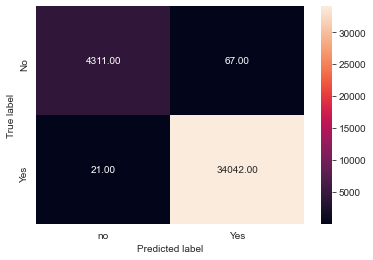

In [89]:
cm = metrics.confusion_matrix( y_test, y_pred_class)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["no", "Yes"] , yticklabels = ["No", "Yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [90]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGBoosting','ANN','ANN + logistic','OneVsRest + XGBoosting','sm'],
    
    'Score': [acc_log,acc_rmf,acc_xgb,acc_mlp,acc_mlp_ln,acc_one_xgb,acc_svm]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
6,sm,0.985640
3,ANN,0.985458
1,Random Forest,0.980281
4,ANN + logistic,0.978513
2,XGBoosting,0.976718
5,OneVsRest + XGBoosting,0.976718
0,Logistic Regression,0.964231


In [93]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'ANN','ANN + logistic','svm1'],
    
    'Score': [acc_log1,acc_rmf1,acc_mlp1,acc_mlp_ln1,acc_svm1]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,svm1,0.997711
0,Logistic Regression,0.997607
3,ANN + logistic,0.995968
1,Random Forest,0.995942
2,ANN,0.890976


##### We got best accuracy by SVM

### Unsupervised Learning

In [66]:
# Data Selection
dff = st_mkt[['headline_text']]

In [68]:
dff['headline_token'] = dff['headline_text'].astype(str).map(word_tokenize)

#### K-Means Clustering

In [69]:
from nltk.util import ngrams

#### Removal of Punctuations and conversion to Lower-case

In [70]:
def remove_punctuations(text):
    text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)                # Remove punctuations
    text=text.lower()                                       # Convert text to lower
    return(text)

dff['headline_text']=dff['headline_text'].apply( lambda x: remove_punctuations(x))
dff['headline_text'].head(4)

276          car dealers caught in bihar sales tax ruling
4500    re-negotiation best: deshmukh; lenders' sos to...
4567         samsung says hello to cellular unit in india
4574              govt lifts port-linked curbs on imports
Name: headline_text, dtype: object

In [92]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5)
vectorizer.fit(dff['headline_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [93]:
X_train = vectorizer.transform(dff['headline_text'])
vocab = vectorizer.get_feature_names()

In [94]:
vocab[:10]

['00', '000', '000cr', '009', '01', '010', '02', '025', '03', '04']

In [95]:
# get the tf-idf table 
vectorizer = TfidfVectorizer(min_df = 3, max_df=0.7,
                             ngram_range=(1, 3), 
                             stop_words='english')
vectorizer.fit(dff['headline_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=None,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [96]:
# Create a training data
X_train = vectorizer.transform(dff['headline_text'])

In [103]:
# Use SVD to reduce dimensions
svd = TruncatedSVD(2000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X_train)

In [104]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 40%


In [105]:
cluster_range = range( 3,9 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( n_clusters=n_clusters )
    clusters.fit( X_lsa )
    cluster_errors.append( clusters.inertia_ )

In [106]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,3,151080.527172
1,4,150876.063090
2,5,150808.929333
3,6,150808.929042
4,7,150808.929135
5,8,150793.137180


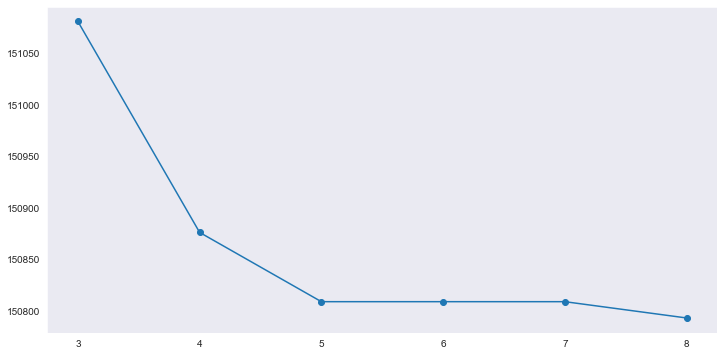

In [107]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

##### Best number of clusters are 5 by Elbow Analysis.

In [109]:
# we create a kmeans model
model = KMeans(n_clusters=5, 
               init='k-means++', 
               max_iter=100, n_init=1,random_state=5)

In [110]:
# apply the model on this prepared data
res = model.fit(X_train)
res

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)

In [111]:
# Getting the vocalbulary as well as cluster centers
# Firstly, set of words from the tf-idf itself
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab) 

In [112]:
# Then, the cluster centers from the model fit that we stored on res
cluster_centers = np.array(res.cluster_centers_)

In [113]:
x=np.array((0.1,10,0.05,1.5))
print(x)
print(x.argsort())
res.cluster_centers_[0].argsort()

[ 0.1  10.    0.05  1.5 ]
[2 0 3 1]


array([    0, 49085, 49086, ..., 54947, 32169, 52295], dtype=int64)

In [114]:
# sorting the cluster centers
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [115]:
# get top 10 words from that cluster
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
    print(words)

{'price', 'rate hike', 'fuel', 'prices', 'price hike', 'rate', 'diesel', 'petrol diesel', 'hike', 'petrol'}
{'india', 'air india', '000', 'watch', 'fuel', 'prices', 'price hike', 'rate', 'crore', 'cr', 'air', 'petrol', 'price', 'rate hike', 'factors watch', 'diesel', 'petrol diesel', 'hike', 'factors', 'rs'}
{'india', 'public sector', 'psu banks', 'air india', '000', 'watch', 'loan', 'fuel', 'prices', 'price hike', 'rate', 'crore', 'cr', 'air', 'public sector banks', 'petrol', 'sector banks', 'price', 'loans', 'banks', 'rate hike', 'rbi', 'factors watch', 'psu', 'rates', 'diesel', 'petrol diesel', 'hike', 'factors', 'rs'}
{'india', 'psu banks', 'air india', 'fuel', 'prices', 'govt plans', 'price hike', 'rate', 'plans', 'price', 'govt', 'banks', 'rbi', 'rates', 'diesel', 'petrol diesel', 'hike', 'rs', 'public sector', '000', 'watch', 'loan', 'crore', 'cr', 'air', 'govt mulls', 'gas', 'public sector banks', 'fdi', 'petrol', 'sector banks', 'loans', 'rate hike', 'factors watch', 'psu', 't

In [116]:
words=list(words)

In [117]:
#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [118]:
#train_set[,]
dff.head()

,headline_text,headline_token
276,car dealers caught in bihar sales tax ruling,"[Car, dealers, caught, in, Bihar, sales, tax, ..."
4500,re-negotiation best: deshmukh; lenders' sos to...,"[Re-negotiation, best, :, Deshmukh, ;, lenders..."
4567,samsung says hello to cellular unit in india,"[Samsung, says, hello, to, cellular, unit, in,..."
4574,govt lifts port-linked curbs on imports,"[Govt, lifts, port-linked, curbs, on, imports]"
4587,ril plans to mop up to rs 1;000cr,"[RIL, plans, to, mop, up, to, Rs, 1, ;, 000cr]"


In [119]:
# how many observations are in each cluster
dff['cluster'] = model.labels_
dff.groupby('cluster').count()

,headline_text,headline_token
cluster,,
0,2973,2973
1,19968,19968
2,2307,2307
3,4527,4527
4,123989,123989


In [120]:
# what does each cluster look like
dff.head()

,headline_text,headline_token,cluster
276,car dealers caught in bihar sales tax ruling,"[Car, dealers, caught, in, Bihar, sales, tax, ...",4
4500,re-negotiation best: deshmukh; lenders' sos to...,"[Re-negotiation, best, :, Deshmukh, ;, lenders...",4
4567,samsung says hello to cellular unit in india,"[Samsung, says, hello, to, cellular, unit, in,...",1
4574,govt lifts port-linked curbs on imports,"[Govt, lifts, port-linked, curbs, on, imports]",3
4587,ril plans to mop up to rs 1;000cr,"[RIL, plans, to, mop, up, to, Rs, 1, ;, 000cr]",1
